# Operacja "Fajerwerk" 🎆

Witaj w zadaniu, w którym wcielisz się w rolę inżyniera pirotechnika... wspomaganego przez sztuczną inteligencję.

Twoim celem jest wystrzelenie ładunku fajerwerkowego tak, aby **wybuchł idealnie w wyznaczonym punkcie na niebie $(x, y)$**.

Masz do dyspozycji armatę, w której możesz regulować dwa parametry:
1. **Kąt wystrzału** (w stopniach).
2. **Siłę wystrzału** (prędkość początkową).

Każdy ładunek ma zapalnik czasowy ustawiony na konkretny czas $T$ (np. 3.0 sekundy). Musisz tak dobrać parametry wystrzału, aby po upływie tego czasu pocisk znajdował się dokładnie w środku celu.

### Dlaczego PyTorch?
Zwykle używamy go do sieci neuronowych. Ale PyTorch to tak naprawdę potężny silnik do obliczania pochodnych (gradientów). Jeśli napiszemy symulację fizyczną używając tensorów PyTorcha, będziemy mogli policzyć gradient błędu (odległości wybuchu od celu) względem parametrów działa. 

To pozwoli nam "nauczyć" działo trafiać w cel metodą Gradient Descent, **bez używania żadnych sieci neuronowych (`nn.Module`)**.

## 1. Importy i Konfiguracja

Standardowy zestaw. Używamy `torch` do obliczeń i `matplotlib` do rysowania trajektorii.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from typing import Tuple, List

# Ustawiamy ziarno losowości dla powtarzalności
torch.manual_seed(42)

# Wykrywanie urządzenia (CPU/GPU) - dla tego zadania CPU jest wystarczające i często szybsze (mały narzut)
device = "cpu"

## 2. Symulator Fizyczni

Poniżej znajduje się funkcja `simulate_shot`. Jest to nasz "silnik fizyczny". 

**Jak to działa?**
1. Przyjmuje parametry startowe (kąt, siła).
2. Symuluje lot pocisku przez zadany czas `total_time` używając stałego kroku czasowego `dt`.
3. Zwraca współrzędne $(x, y)$, w których znajduje się pocisk w momencie detonacji (końca czasu).

In [2]:
def simulate_shot(
    angle_deg: torch.Tensor, 
    force: torch.Tensor, 
    total_time: float,
    wind: float = 0.0, 
    gravity: float = 9.81,
    dt: float = 0.05 
) -> Tuple[torch.Tensor, torch.Tensor, Tuple[List[float], List[float]]]:
    """
    Symuluje lot pocisku przez zadany czas total_time.
    
    Args:
        angle_deg: Kąt w stopniach (Tensor, requires_grad=True).
        force: Siła/Prędkość początkowa (Tensor, requires_grad=True).
        total_time: Czas do detonacji (float).
        wind: Siła wiatru (dodatnia = w plecy, ujemna = w twarz).
        gravity: Przyspieszenie ziemskie.
        dt: Krok czasowy symulacji.
    
    Returns:
        final_x: Tensor współrzędnej X w momencie wybuchu.
        final_y: Tensor współrzędnej Y w momencie wybuchu.
        trajectory: (xs, ys) - listy współrzędnych do wizualizacji.
    """
    
    # Zamiana stopni na radiany
    angle_rad = torch.deg2rad(angle_deg)
    
    # Rozkład wektora prędkości
    vx = force * torch.cos(angle_rad)
    vy = force * torch.sin(angle_rad)
    
    # Pozycja startowa
    x = torch.tensor(0.0)
    y = torch.tensor(0.0)
    
    # Listy do zbierania historii (do wykresu)
    xs = [x.item()]
    ys = [y.item()]
    
    # Obliczamy liczbę kroków symulacji
    # Rzutowanie na int jest bezpieczne, bo total_time i dt są stałymi floatami (nie tensorami)
    steps = int(total_time / dt)
    
    for step in range(steps):
        # Aktualizacja pozycji
        x = x + vx * dt
        y = y + vy * dt
        
        # Aktualizacja prędkości
        vy = vy - gravity * dt
        vx = vx + wind * dt
        
        # Zapis do historii (używamy .item() by nie zapychać pamięci grafem autograda)
        xs.append(x.item())
        ys.append(y.item())
            
    return x, y, (xs, ys)

## 3. Narzędzie Wizualizacji

Pomocnicza funkcja, która narysuje cel na niebie oraz trajektorię lotu.

In [3]:
def plot_trajectory(target_x, target_y, trajectories, title="Symulacja"):
    plt.figure(figsize=(10, 6))
    
    # Rysuj ziemię
    plt.axhline(0, color='black', linewidth=2)
    
    # Rysuj trajektorie
    # trajectories to lista krotek: (xs, ys, label, color)
    for xs, ys, label, color in trajectories:
        plt.plot(xs, ys, label=label, color=color, alpha=0.8)
        # Zaznaczamy punkt wybuchu kropką
        plt.plot(xs[-1], ys[-1], 'o', color=color, markersize=6)

        
    # Rysuj cel w powietrzu
    plt.plot(target_x, target_y, 'r*', markersize=10, markeredgewidth=2, label='Cel')
    
    plt.title(title)
    plt.xlabel("Dystans (m)")
    plt.ylabel("Wysokość (m)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal') # Ważne, żeby zachować proporcje
    plt.ylim(bottom=-5)
    plt.show()

### Test manualny
Sprawdźmy, czy symulator działa. Strzelmy pod kątem 60 stopni z siłą 50 przez 4 sekundy.

Detonacja w punkcie: (136.40, 34.45)


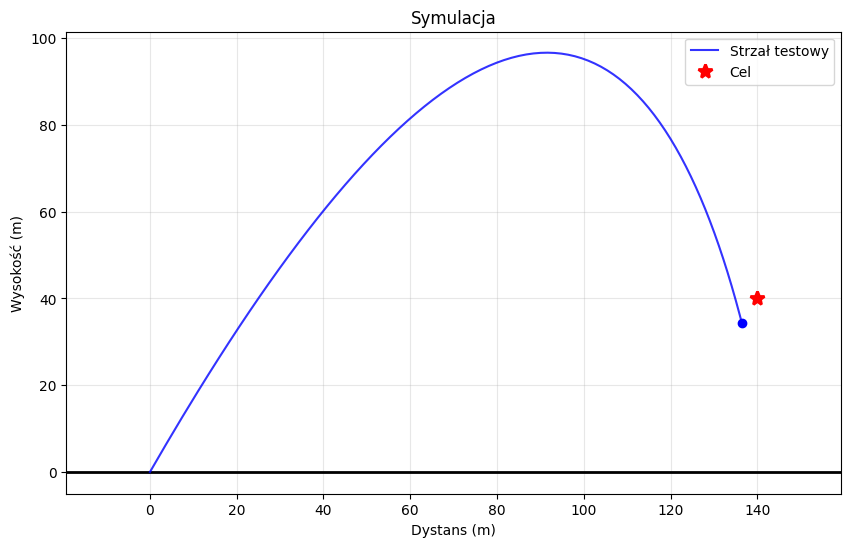

In [4]:
# Przykładowy strzał
angle = torch.tensor(60.0)
force = torch.tensor(50.0)
time_to_explode = 8.0

final_x, final_y, (xs, ys) = simulate_shot(angle, force, total_time=time_to_explode, wind=-2.0)

print(f"Detonacja w punkcie: ({final_x.item():.2f}, {final_y.item():.2f})")

# Rysujemy przykładowy cel w pobliżu miejsca wybuchu, żeby zobaczyć wykres
plot_trajectory(140, 40, [(xs, ys, 'Strzał testowy', 'blue')])

## 4. Zadanie: Optymalizacja parametrów

Twoim zadaniem jest napisanie funkcji `find_cannon_configuration`.

Otrzymujesz współrzędne celu `(target_x, target_y)` oraz informacje o symulacji (`simulation_time`, `wind_force`, `gravity`). Musisz znaleźć `angle` i `force`.

**Algorytm działania:**
1. Zainicjuj losowo parametry `angle` i `force` (pamiętaj o `requires_grad=True`).
2. W pętli (np. 100 kroków):
- Uruchom symulację `simulate_shot`.
- Policz stratę (Loss). Możesz zrobić eksperymenty z różnymi metodami! Uwaga, kwadrat różnicy może w teorii być spory, dlatego Learning Rate musi być całkiem mały.
- Wywołaj `loss.backward()`.
- Zaktualizuj parametry (Gradient Descent).
- Pamiętaj o wyzerowaniu gradientów.

**Wskazówki:**
* Po każdym kroku algorytmu, możesz użyć `.clamp()`, aby utrzymać kąt i siłę w wymaganych przedziałach (patrz [torch.clamp](https://docs.pytorch.org/docs/stable/generated/torch.clamp.html))

In [11]:
def find_cannon_configuration(
    target_x: float,
    target_y: float,
    simulation_time: float,
    wind_force: float,
    gravity: float,
    create_plots: bool = True,
) -> Tuple[float, float]:
    
    if create_plots:
        print(f"--- Celowanie w punkt ({target_x:.1f}, {target_y:.1f}) na czas {simulation_time}s --- ")
    
    history_trajectories = []  # Potrzebne do wykresów
    
    # --- TU WPISZ SWÓJ KOD ---
    iterations = 100

    for i in range(iterations):
        # final_x, final_y, (xs, ys) = simulate_shot(...)

        # Zbieramy dane do wykresu co 20 iteracji
        if create_plots and (i % 20 == 0 or i == iterations - 1):
            color = plt.cm.plasma(i / iterations) # Kolor od fioletu do żółtego
            history_trajectories.append((xs, ys, f'Iter {i}', color))
            print(f"Iter {i}: Loss {loss.item():.2f} | Cel: ({target_x:.1f}, {target_y:.1f}) -> Trafienie: ({final_x.item():.1f}, {final_y.item():.1f})")
    
    if create_plots:
        plot_trajectory(target_x, target_y, history_trajectories, title=f"Proces celowania (Wiatr: {wind_force})")

    return angle_param.item(), force_param.item()

## 5. Weryfikacja

Sprawdźmy, jak Twoja "Sztuczna Inteligencja" radzi sobie w różnych scenariuszach.

--- Celowanie w punkt (-200.0, 150.0) na czas 4.0s --- 
Iter 0: Loss 50797.89 | Cel: (-200.0, 150.0) -> Trafienie: (23.7, 122.5)
Iter 20: Loss 15972.36 | Cel: (-200.0, 150.0) -> Trafienie: (-74.4, 136.1)
Iter 40: Loss 3674.81 | Cel: (-200.0, 150.0) -> Trafienie: (-140.5, 138.6)
Iter 60: Loss 800.59 | Cel: (-200.0, 150.0) -> Trafienie: (-173.4, 140.2)
Iter 80: Loss 190.98 | Cel: (-200.0, 150.0) -> Trafienie: (-188.0, 143.2)
Iter 99: Loss 52.67 | Cel: (-200.0, 150.0) -> Trafienie: (-194.1, 145.7)


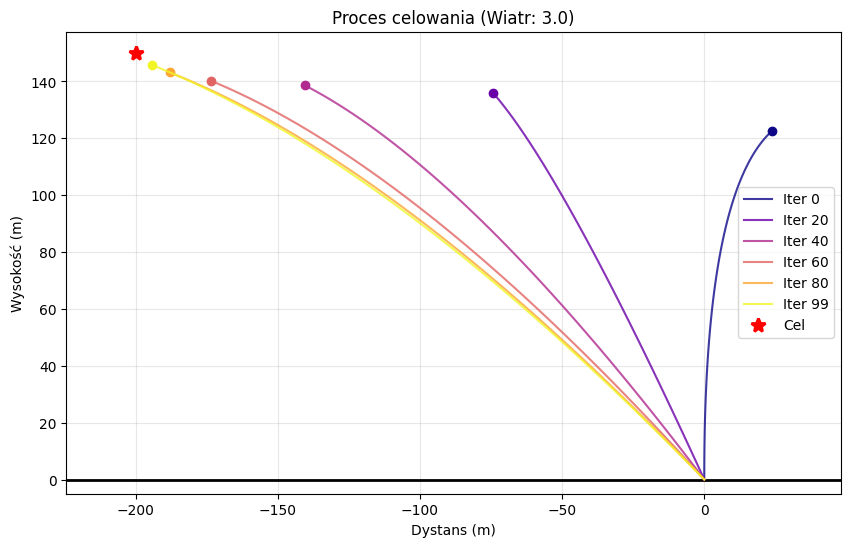

WYNIK: Kąt 134.31, Siła 78.03


In [6]:
# Scenariusz 1: Wysoki pułap, wiatr w plecy
angle, force = find_cannon_configuration(
    target_x=-200.0, target_y=150.0, 
    simulation_time=4.0, wind_force=3.0, gravity=9.81
)
print(f"WYNIK: Kąt {angle:.2f}, Siła {force:.2f}")

--- Celowanie w punkt (300.0, 50.0) na czas 3.5s --- 
Iter 0: Loss 113349.74 | Cel: (300.0, 50.0) -> Trafienie: (-30.2, 115.8)
Iter 20: Loss 53161.97 | Cel: (300.0, 50.0) -> Trafienie: (74.1, 95.9)
Iter 40: Loss 18656.16 | Cel: (300.0, 50.0) -> Trafienie: (165.3, 72.9)
Iter 60: Loss 5703.39 | Cel: (300.0, 50.0) -> Trafienie: (224.5, 51.4)
Iter 80: Loss 1907.84 | Cel: (300.0, 50.0) -> Trafienie: (256.8, 43.8)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Iter 99: Loss 723.10 | Cel: (300.0, 50.0) -> Trafienie: (273.9, 43.7)


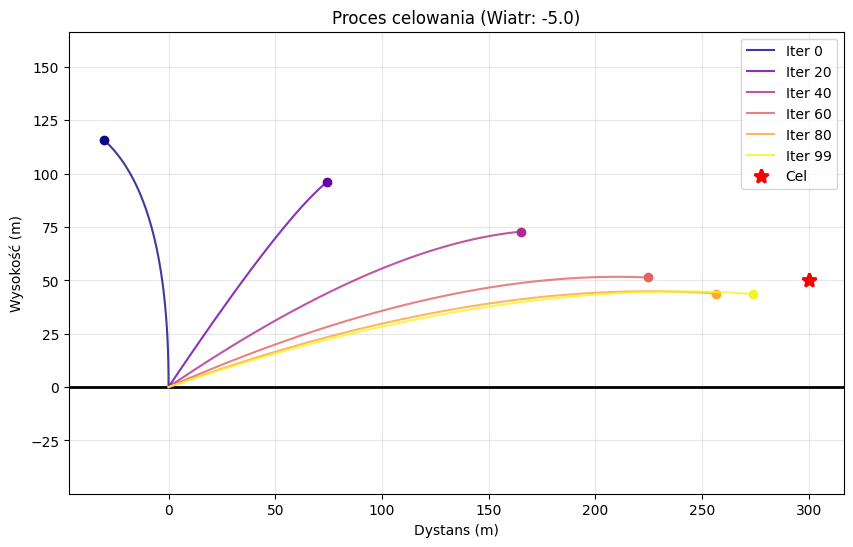

WYNIK: Kąt 18.67, Siła 91.90


In [7]:
# Scenariusz 2: Nisko i daleko, silny wiatr w twarz
angle, force = find_cannon_configuration(
    target_x=300.0, target_y=50.0, 
    simulation_time=3.5, wind_force=-5.0, gravity=9.81
)
print(f"WYNIK: Kąt {angle:.2f}, Siła {force:.2f}")

## 6. Zgłoszenie

Poniższy kod ocenia Twoje rozwiązanie.

## Kryterium oceny – Accuracy (trafienia)

Za każdy strzał, którego wynik (punkt detonacji) znajduje się w odległości **nie większej niż 0.5 m** od celu, otrzymujesz **1 punkt**. W przeciwnym przypadku – **0 punktów**.

Końcowy wynik to **średnia arytmetyczna** ze wszystkich punktów:

$$
\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}\left[\sqrt{(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2} \le 0.5\right]
$$

gdzie $\mathbb{1}[\cdot]$ to funkcja wskaźnikowa (1 jeśli warunek spełniony, 0 w przeciwnym razie).

### Ograniczenia armaty

Armata ma fizyczne ograniczenia parametrów:
* **Kąt wystrzału**: od 5° do 175° (90° = strzał pionowo w górę, 0° = poziomo w prawo)
* **Siła wystrzału**: od 10 do 150

Jeśli zgłoszone parametry wykraczają poza te zakresy, strzał jest **automatycznie uznawany za pudło** (0 punktów).

### Punktacja

* Aby uzyskać **1 punkt** (maksimum), musisz trafić **wszystkie cele** z wymaganą dokładnością.
* Punkty są proporcjonalne do liczby trafień: $\text{punkty} = \text{Accuracy}$

In [12]:
print("--- Generowanie rozwiązań do sprawdzarki ---")

data = np.load("test.npz")
txs = data['target_xs']
tys = data['target_ys']
times = data['times']
winds = data['winds']
gravs = data['gravities']

sol_angles = []
sol_forces = []

# Ograniczenia armaty
ANGLE_MIN, ANGLE_MAX = 5, 175
FORCE_MIN, FORCE_MAX = 10, 150
HIT_THRESHOLD = 0.5  # maksymalna odległość dla trafienia

hits = 0
total = len(txs)

start_time = time.time()

for i in range(total):
    if i % 5 == 0: print(f"Przetwarzanie {i}/{total}...")

    angle_res, force_res = find_cannon_configuration(
        target_x=txs[i], 
        target_y=tys[i],
        simulation_time=times[i],
        wind_force=winds[i], 
        gravity=gravs[i], 
        create_plots=False 
    )
    
    sol_angles.append(angle_res)
    sol_forces.append(force_res)
    
    # Sprawdzenie ograniczeń armaty
    if not (ANGLE_MIN <= angle_res <= ANGLE_MAX) or not (FORCE_MIN <= force_res <= FORCE_MAX):
        # Parametry poza zakresem = automatyczne pudło
        print(f"  ⚠️ Strzał {i}: parametry poza zakresem (kąt={angle_res:.2f}, siła={force_res:.2f})")
        continue
    
    # Obliczenie odległości od celu
    with torch.no_grad():
        fx, fy, _ = simulate_shot(
            torch.tensor(angle_res), torch.tensor(force_res), 
            times[i], winds[i], gravs[i]
        )
        distance = torch.sqrt((fx - txs[i])**2 + (fy - tys[i])**2).item()
        
        if distance <= HIT_THRESHOLD:
            hits += 1

end_time = time.time()
accuracy = hits / total

print(f"\n{'='*50}")
print(f"Zakończono! Czas: {end_time - start_time:.2f}s")
print(f"Trafienia: {hits}/{total}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'='*50}")

if accuracy == 1.0:
    print("✅ Perfekcyjny wynik! Wszystkie cele trafione.")
elif accuracy >= 0.8:
    print("👍 Dobry wynik! Większość celów trafiona.")
else:
    print("⚠️ Wynik wymaga poprawy. Spróbuj zmienić learning rate lub liczbę iteracji.")

np.savez("solution.npz", angles=sol_angles, forces=sol_forces)

--- Generowanie rozwiązań do sprawdzarki ---
Przetwarzanie 0/20...
Przetwarzanie 5/20...
Przetwarzanie 10/20...
Przetwarzanie 15/20...

Zakończono! Czas: 63.35s
Trafienia: 20/20
Accuracy: 1.0000 (100.00%)
✅ Perfekcyjny wynik! Wszystkie cele trafione.


## 7. Podpowiedź

Jeśli nie masz pewności, jak działa optymalizacja gradientowa w PyTorch, poniżej znajduje się prosty przykład.

**Cel:** Znaleźć wartość parametru `x`, która minimalizuje funkcję `loss = (x - 10)²`.

Oczywiście wiemy, że odpowiedzią jest `x = 10`, ale pokażemy, jak PyTorch może to znaleźć automatycznie używając gradientów.

In [10]:
# 1. Inicjalizacja parametru (losowa wartość startowa)
x = torch.tensor(0.0, requires_grad=True)

# Parametry uczenia
learning_rate = 0.1
iterations = 50

print("Optymalizacja parametru x, aby zminimalizować (x - 10)²\n")

for i in range(iterations):
    # 2. Obliczenie funkcji straty
    loss = (x - 10) ** 2
    
    # 3. Wsteczna propagacja (obliczenie gradientu)
    loss.backward()
    
    # 4. Aktualizacja parametru
    with torch.no_grad():
        x -= learning_rate * x.grad
        
        # 5. Zerowanie gradientu
        x.grad.zero_()
    
    # Wyświetlamy postęp co 10 iteracji
    if i % 10 == 0 or i == iterations - 1:
        print(f"Iteracja {i:2d}: x = {x.item():.4f}, loss = {loss.item():.4f}")

print(f"\n✅ Znaleziona wartość: x = {x.item():.4f} (oczekiwana: 10.0)")

Optymalizacja parametru x, aby zminimalizować (x - 10)²

Iteracja  0: x = 2.0000, loss = 100.0000
Iteracja 10: x = 9.1410, loss = 1.1529
Iteracja 20: x = 9.9078, loss = 0.0133
Iteracja 30: x = 9.9901, loss = 0.0002
Iteracja 40: x = 9.9989, loss = 0.0000
Iteracja 49: x = 9.9999, loss = 0.0000

✅ Znaleziona wartość: x = 9.9999 (oczekiwana: 10.0)
